
The main notebook for Coloring GAN using VGG16 weights



In [1]:
!unzip -q '/content/drive/My Drive/BE_project/data.zip'

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#tf.compat.v1.disable_v2_behavior()

1 Physical GPUs, 1 Logical GPUs


In [23]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Add
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16

import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt
import csv

This part is only for displaying the time for epochs in a formatted fashion. Do not play around over here

In [4]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [5]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 64 # rows/cols (should be square)
GEN_IMAGE_CHANNELS = 3
INPUT_IMAGE_CHANNELS = 1

# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 3
PREVIEW_MARGIN = 8

# Size vector to generate images from
SEED_SIZE = 1

# Configuration
if(not os.path.exists('/content/drive/My Drive/BE_project/output/colorised/')):
  path = '/content/drive/My Drive/BE_project/output/colorised/'
  os.makedirs(path)
  print(f"Created new directory: {path}")

DATA_PATH = '/content/drive/My Drive/BE_project/output/colorised/'
TRAIN_PATH = '/content/dataset/'

log_file = '/content/drive/My Drive/BE_project/output/training_history.csv'

EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


These are the data generators used for producing batches of colored and subsequent black and white images

In [6]:
bw_datagen = ImageDataGenerator(
    rescale= 1./255,
)

bw_image_generator = bw_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode=None,
    color_mode="grayscale",
    batch_size=16,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=None,
    shuffle=False
)


cl_datagen = ImageDataGenerator(
    rescale= 1./255
)

cl_image_generator = cl_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode=None,
    color_mode="rgb",
    batch_size=16,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=None,
    shuffle=False
)

Found 4776 images belonging to 1 classes.
Found 4776 images belonging to 1 classes.


We build our generator network

<Figure size 432x288 with 0 Axes>

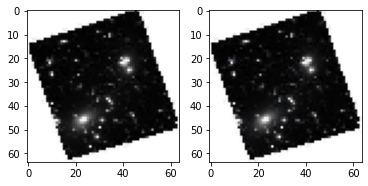

In [7]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
i = 0
for bw_image, cl_image in zip(bw_image_generator, cl_image_generator):
  if(i<40):
    i+=1
    continue
  bw = np.concatenate((bw_image,)*3, axis=-1)
  axarr[0].imshow(bw[0])
  axarr[1].imshow(cl_image[0])
  break

In [8]:
def build_generator(channels, image_shape = (720,720,1)):
    input_tensor = Input(shape=image_shape)
    X = Conv2D(filters = 3, kernel_size=3, padding='same', name="input_conv")(input_tensor)
    #X = UpSampling2D(size=(4,4), name='upsample_input')(X)
    X = Conv2DTranspose(3, (1,1), strides=(4,4), input_shape=(64,64, 3), name='input_conv2d_transpose')(X)

    vgg16 = VGG16(include_top=False, weights='imagenet',input_shape=(256,256,3))
    
    block = 1
    for i in range(1,len(vgg16.layers)):
        if(vgg16.layers[i].name == 'block3_pool'):
            break
        if(f'block{block}' in vgg16.layers[i].name):
            X = Conv2D(filters = vgg16.layers[i].input_spec.axes[-1], kernel_size = (3,3), padding='same', name=f"custom_block_conv{block}")(X)
            block+=1
        X = vgg16.layers[i](X)

    X =  Conv2D(filters = channels, kernel_size=3, padding='same', name='output_conv')(X)
    X = Activation('tanh', name='output_activation')(X)

    model = Model(inputs = input_tensor, outputs = X, name='Generator')
    
    custom_layers = set(['input_conv','upsample_input','output_conv','output_activation','input_conv2d_transpose'])
    
    for layer in model.layers:
        if(layer.name not in custom_layers and 'custom' not in layer.name):
            layer.trainable = False
    
    return model

We build the discriminator network

In [19]:
def build_discriminator(image_shape=(720,720,3)):
    vgg16 = VGG16(include_top=False, weights='imagenet',input_shape=image_shape)
    i=1
    for layer in vgg16.layers:
        if(i%2):
            i+=1
            continue
        layer.trainable = False
    
    X_shortcut = vgg16.output
    
    X = Dropout(0.25)(vgg16.output)
    X = Conv2D(filters = 256, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Dropout(0.25)(X)
    X = Conv2D(filters = 512, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X_shortcut = Conv2D(filters = 512, kernel_size = (3,3), strides=1, padding='same')(X_shortcut)
    X_shortcut = BatchNormalization(momentum=0.8)(X_shortcut)
    X_shortcut = LeakyReLU(alpha=0.2)(X_shortcut)
    
    X = Add(name='addition_layer')([X,X_shortcut])

    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs = vgg16.input, outputs = X, name='Discriminator')

    return model

Let's create an instance of network optimizers. We'll use them later on to apply weights using gradient tape. For now, we'll just initialize them with appropriate names

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

We see how our generator network performs with initialized weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


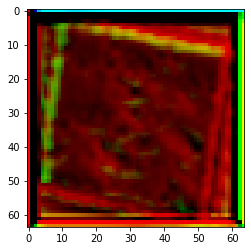

In [21]:
generator = build_generator(GEN_IMAGE_CHANNELS,(GENERATE_SQUARE,GENERATE_SQUARE,INPUT_IMAGE_CHANNELS))

bw_image = bw_image_generator.next()

generated_image = generator(bw_image, training=False)

plt.imshow(generated_image[0, :, :])

Our discriminator provides us with little to no result

In [24]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,GEN_IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision[0])

tf.Tensor([0.51397145], shape=(1,), dtype=float32)


We're setting up the loss function for our generator and discriminator. That's the log loss or the binary crossentropy loss defined accordingly in the report

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The train step is where we'll process a batch of images and calculate the loss of generator and discriminator. We'll apply the gradient descent values to the variables

In [ ]:
@tf.function
def train_step(bw_images, cl_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Get the generated image batch by passing the grayscale images through the generator
        generated_images = generator(bw_images, training=True)
        
        real_output = discriminator(cl_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        #Calculate the losses of the networks
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #Get the gradients using gradient tape
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        #Apply the gradients so update variables
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [ ]:
#This cell contains all the "callback" type functionalities
def save_images(cnt,bw_images, cl_images):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict(bw_images)

    generated_images = 0.5 * generated_images + 0.5

    bw_image = np.concatenate((bw_images[0],)*3, axis = -1)

    original_image = cl_images[0]

    final_images = np.array([bw_image,generated_images[0],original_image])

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+8) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+8) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = final_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)


def csv_logger(dictionary, field_names, file_name, header=False):
  with open(file_name, 'a') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    if(header):
      writer.writeheader()
    writer.writerow(dictionary)

In [ ]:
def train(gen_generator, disc_generator, epochs, steps_per_epoch):
    start = time.time()
    metrics = {'gen_loss':[], 'disc_loss':[]}
    field_names = ['Epoch', 'gen_loss', 'disc_loss']

    header = True
    for epoch in range(epochs):
        epoch_start = time.time()
        if(epoch>0):
          header = False
            
        gen_loss_list = []
        disc_loss_list = []
        
        bw_batch = []
        cl_batch = []
        
        steps = 0
        
        for bw_imagebatch, cl_imagebatch in zip(gen_generator,disc_generator):
            if(steps>steps_per_epoch):
                break
            if(len(bw_batch)<8):
                for i in range(bw_imagebatch.shape[0]):
                    bw_batch.append(bw_imagebatch[i])
                    cl_batch.append(cl_imagebatch[i])
            t = train_step(bw_imagebatch, cl_imagebatch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            steps+=1

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        metrics['gen_loss'].append(g_loss.numpy())
        metrics['disc_loss'].append(d_loss.numpy())

        #Log the epoch losses
        log = {'Epoch': epoch+1, 'gen_loss': g_loss.numpy(), 'disc_loss': d_loss.numpy()}
        csv_logger(log, field_names, log_file, header)

        epoch_elapsed = time.time()-epoch_start
        
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, epoch_time={hms_string(epoch_elapsed)}')
        save_images(epoch,np.array(bw_batch), np.array(cl_batch))

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

    return metrics

In [ ]:
print(generator.summary())
print("\n\n")
print(discriminator.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
input_conv (Conv2D)          (None, 64, 64, 3)         30        
_________________________________________________________________
input_conv2d_transpose (Conv (None, 256, 256, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73

In [ ]:
#Plot model only when necessary

'''
tf.keras.utils.plot_model(
    generator,
    to_file = 'generator.png',
    show_shapes = True,
    show_layer_names = True,
    expand_nested = True,
    dpi = 96
)
'''

"\ntf.keras.utils.plot_model(\n    generator,\n    to_file = 'generator.png',\n    show_shapes = True,\n    show_layer_names = True,\n    expand_nested = True,\n    dpi = 96\n)\n"

In [ ]:
#Plot model only when necessary

'''
tf.keras.utils.plot_model(
    discriminator,
    to_file = 'discriminator.png',
    show_shapes = True,
    show_layer_names = True,
    expand_nested = True,
    dpi = 96
)
'''

In [ ]:
steps_per_epoch = int(np.ceil(bw_image_generator.n/bw_image_generator.batch_size))

history = train(bw_image_generator, cl_image_generator, EPOCHS, steps_per_epoch)

Epoch 1, gen loss=12.318286895751953,disc loss=8.257023728219792e-05, epoch_time=0:01:37.24
Epoch 2, gen loss=13.01875114440918,disc loss=5.3968458814779297e-05, epoch_time=0:01:37.06
Epoch 3, gen loss=12.557870864868164,disc loss=9.987247176468372e-05, epoch_time=0:01:37.04
Epoch 4, gen loss=12.965279579162598,disc loss=8.153387170750648e-05, epoch_time=0:01:36.95
Epoch 5, gen loss=12.989309310913086,disc loss=2.4868562832125463e-05, epoch_time=0:01:36.95
Epoch 6, gen loss=13.542712211608887,disc loss=2.0762512576766312e-05, epoch_time=0:01:36.95
Epoch 7, gen loss=13.874381065368652,disc loss=1.8598640963318758e-05, epoch_time=0:01:36.98
Epoch 8, gen loss=14.167265892028809,disc loss=1.464298020437127e-05, epoch_time=0:01:36.90
Epoch 9, gen loss=14.191975593566895,disc loss=1.2920325389131904e-05, epoch_time=0:01:36.93
Epoch 10, gen loss=14.199726104736328,disc loss=1.4102275599725544e-05, epoch_time=0:01:36.93
Epoch 11, gen loss=15.809355735778809,disc loss=0.031192496418952942, epoc

In [ ]:
generator.save(os.path.join(DATA_PATH,"color_generator.h5"))